## Executive Summary

----

This report has been completed for a Switzerland based medical device manufacturer. The company sells directly to individual doctors who use these devices for rehabilitation and physical therapy patients. Historically, customers have been segmented by their respective regions, however, this has not been a reliable indicator of how many purchases a customer will make or what their support needs will be. This report will assist the marketing, customer service, and product teams by providing a data centric roadmap. More specifically, the report will focus on addressing the below questions:

>1. How many doctors are there in each region? What is the average number of purchases per region?
>2. Can you find a relationship between purchases and complaints?
>3. Define new doctor segments that help the company improve marketing efforts and customer service.
>4. Identify which features impact the new segmentation strategy the most.
>5. Describe which characteristics distinguish the newly defined segments.

## 💾 The data

The company stores the information you need in the following four tables. Some of the fields are anonymized to comply with privacy regulations.

#### Doctors contains information on doctors. Each row represents one doctor.
- "DoctorID" - is a unique identifier for each doctor.
- "Region" - the current geographical region of the doctor.
- "Category" - the type of doctor, either 'Specialist' or 'General Practitioner.'
- "Rank" - is an internal ranking system. It is an ordered variable: The highest level is Ambassadors, followed by Titanium Plus, Titanium, Platinum Plus, Platinum, Gold Plus, Gold, Silver Plus, and the lowest level is Silver.
- "Incidence rate"  and "R rate" - relate to the amount of re-work each doctor generates.
- "Satisfaction" - measures doctors' satisfaction with the company.
- "Experience" - relates to the doctor's experience with the company.
- "Purchases" - purchases over the last year.

#### Orders contains details on orders. Each row represents one order; a doctor can place multiple orders.
- "DoctorID" - doctor id (matches the other tables).
- "OrderID" - order identifier.
- "OrderNum" - order number.
- "Conditions A through J" - map the different settings of the devices in each order. Each order goes to an individual patient.

#### Complaints collects information on doctor complaints.
- "DoctorID" - doctor id (matches the other tables).
- "Complaint Type" - the company's classification of the complaints.
- "Qty" - number of complaints per complaint type per doctor.

#### Instructions has information on whether the doctor includes special instructions on their orders.
- "DoctorID" - doctor id (matches the other tables).
- "Instructions" - 'Yes' when the doctor includes special instructions, 'No' when they do not.

## Importing libraries and data

In [61]:
## Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statistics import mode
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
sns.set()

## Importing data
doctors = pd.read_csv('data/doctors.csv')
orders = pd.read_csv('data/orders.csv')
complaints = pd.read_csv('data/complaints.csv')
instructions = pd.read_csv('data/instructions.csv')

In [62]:
## Replace '--' value with NA placeholder
doctors['Satisfaction'] = doctors['Satisfaction'].replace(['--'],np.nan)

In [63]:
doctors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DoctorID        437 non-null    object 
 1   Region          437 non-null    object 
 2   Category        437 non-null    object 
 3   Rank            435 non-null    object 
 4   Incidence rate  437 non-null    float64
 5   R rate          437 non-null    float64
 6   Satisfaction    250 non-null    object 
 7   Experience      437 non-null    float64
 8   Purchases       437 non-null    float64
dtypes: float64(4), object(5)
memory usage: 30.9+ KB


In [64]:
doctors.isna().sum() / len(doctors)

DoctorID          0.000000
Region            0.000000
Category          0.000000
Rank              0.004577
Incidence rate    0.000000
R rate            0.000000
Satisfaction      0.427918
Experience        0.000000
Purchases         0.000000
dtype: float64

In [65]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DoctorID     257 non-null    object
 1   OrderID      257 non-null    object
 2   OrderNum     257 non-null    object
 3   Condition A  257 non-null    bool  
 4   Condition B  257 non-null    bool  
 5   Condition C  248 non-null    object
 6   Condition D  257 non-null    bool  
 7   Condition F  254 non-null    object
 8   Condition G  254 non-null    object
 9   Condition H  257 non-null    bool  
 10  Condition I  257 non-null    bool  
 11  Condition J  149 non-null    object
dtypes: bool(5), object(7)
memory usage: 15.4+ KB


In [66]:
orders.isna().sum() / len(orders)

DoctorID       0.000000
OrderID        0.000000
OrderNum       0.000000
Condition A    0.000000
Condition B    0.000000
Condition C    0.035019
Condition D    0.000000
Condition F    0.011673
Condition G    0.011673
Condition H    0.000000
Condition I    0.000000
Condition J    0.420233
dtype: float64

In [67]:
complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DoctorID        435 non-null    object
 1   Complaint Type  433 non-null    object
 2   Qty             435 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 10.3+ KB


In [68]:
complaints.isna().sum() / len(complaints)

DoctorID          0.000000
Complaint Type    0.004598
Qty               0.000000
dtype: float64

In [69]:
instructions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   DoctorID      77 non-null     object
 1   Instructions  77 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [70]:
instructions.isna().sum() / len(instructions) 

DoctorID        0.0
Instructions    0.0
dtype: float64

## Analysis

### Number of Doctors in each Region

**The number of Doctors per Region varies quite a bit**

- Looking at the distribution of the number of doctors per region, one can see that the data is right skewed. In other words, much of the data is concentrated in the "lower counts" of doctors per region.
- The number of doctors in each region ranges from 1 to 34.
- The median number of doctors per region is 6 while the average is 9.5.
- Region "1 13", "1 14", "1 19", "1 9" are technical outliers (outside of 75th/25th percentile +/- 1.5 * IQR) with 34, 32, 31, and 32 doctors respectively

Text(0.5, 0, 'Count of Doctors')

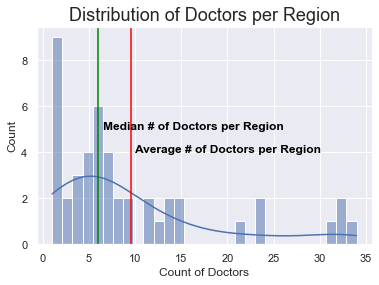

In [71]:
dr_grouped_df = pd.DataFrame(doctors.groupby(by=['Region'])['DoctorID'].count())

sns.histplot(data=dr_grouped_df,x="DoctorID",kde = True,bins = 30)

plt.axvline(x=dr_grouped_df['DoctorID'].mean(),color='red')
plt.axvline(x=dr_grouped_df['DoctorID'].median(),color='green')

plt.text(
    dr_grouped_df['DoctorID'].mean() + 0.5,4,"Average # of Doctors per Region",
    horizontalalignment='left',size='medium',color='black',weight='semibold')

plt.text(
    dr_grouped_df['DoctorID'].median() + 0.5,5,"Median # of Doctors per Region",
    horizontalalignment='left',size='medium',color='black',weight='semibold')

plt.title("Distribution of Doctors per Region",size = 18)
plt.xlabel("Count of Doctors")

In [72]:
LOWER = np.percentile(dr_grouped_df['DoctorID'],q = 25)
UPPER = np.percentile(dr_grouped_df['DoctorID'],q = 75)
IQR = UPPER - LOWER

UPPER_OUT_THRESH = UPPER + (IQR*1.5)
LOWER_OUT_THRESH = LOWER - (IQR*1.5)

dr_grouped_df[(dr_grouped_df['DoctorID'] > UPPER_OUT_THRESH) | (dr_grouped_df['DoctorID'] < LOWER_OUT_THRESH)].index

Index(['1 13', '1 14', '1 19', '1 9'], dtype='object', name='Region')

### Average number of purchases per region

**Similar to the number of doctors per region, number of purchases varies quite a bit per region**

On average, there are about 103 purchases per region. When analyzing the distribution of the number of purchases per region, one can notice that the data is right skewed meaning there are some doctors that are making large purchase orders relative to the other doctors. To get a more meaningful understanding of their average number of purchases per region, we also can look at the data when outliers are excluded. More specifically, we only included data points greater than the lower 25th percentile minus 1.5 times the IQR and less than the 75th percentile plus 1.5 times the IQR. After this data manipulation, the average is 78. One assumption we made about the data was that the number of doctors per region may correlate with the number of purchases per region. This turned out to be an accurate assumption as a correlation test yielded a coefficient of 0.9 with statistical significance.

Text(0.5, 0, 'Sum of Region Purchases')

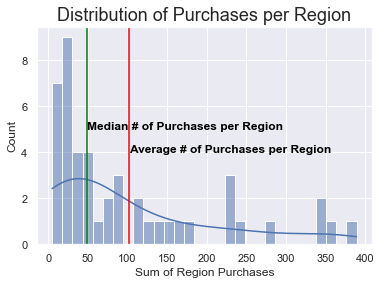

In [73]:
dr_grouped_df_2 = pd.DataFrame(doctors.groupby(by=['Region'])['Purchases'].sum())

sns.histplot(data=dr_grouped_df_2,x="Purchases",kde = True,bins = 30)

plt.axvline(x=dr_grouped_df_2['Purchases'].mean(),color='red')
plt.axvline(x=dr_grouped_df_2['Purchases'].median(),color='green')

plt.text(
    dr_grouped_df_2['Purchases'].mean() + 0.5,4,"Average # of Purchases per Region",
    horizontalalignment='left',size='medium',color='black',weight='semibold')

plt.text(
    dr_grouped_df_2['Purchases'].median() + 0.5,5,"Median # of Purchases per Region",
    horizontalalignment='left',size='medium',color='black',weight='semibold')

plt.title("Distribution of Purchases per Region",size = 18)
plt.xlabel("Sum of Region Purchases")

In [74]:
dr_purchase_df = doctors.groupby(by='Region')['DoctorID','Purchases'].agg({'DoctorID':'count','Purchases':'sum'})
corr, sig = stats.pearsonr(dr_purchase_df['DoctorID'],dr_purchase_df['Purchases'])

print("Correlation Coefficient: ",corr)
print("Significance Level (P value) ",sig)

Correlation Coefficient:  0.908255987693086
Significance Level (P value)  2.9394895922734304e-18


### Purchases and Complaints: Is there a relationship?

**Data may be to limited to say there is a relationship**

For this section of the analysis we have to make use of the 'doctors' and 'complaints' datasets. After merging the 2 datasets, we are left with 74 observations with both complaint and purchase data. This only leaves us with less than 20% of the observations within the 'doctors' dataset. With this information in mind we have to be careful about any conclusions we draw from looking for a relationship between purchases and complaints. Despite this, a correlation test was ran and yielded a coefficient of 0.59 with no significance. Visualizing complaints and purchases with a scatterplot also suggests that there is probably no relationship between the 2.

In [75]:
doctors_purchase_grouped = pd.DataFrame(doctors.groupby(by=['DoctorID'])["Purchases"].sum())
doctors_purchase_grouped = doctors_purchase_grouped.rename(columns = {'index':'DoctorID'})

complaints_grouped_df = pd.DataFrame(complaints.groupby('DoctorID')['Qty'].sum())
complaints_grouped_df = complaints_grouped_df.rename(columns = {'index':'DoctorID'})

complaint_purchase_df = complaints_grouped_df.merge(doctors_purchase_grouped, on='DoctorID', how='left')
complaint_purchase_df = complaint_purchase_df.dropna()

Text(0.5, 1.0, 'Purhcases by # of Complaints')

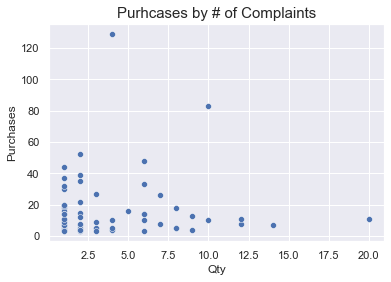

In [76]:
sns.scatterplot(x = "Qty",y = "Purchases",data = complaint_purchase_df)
plt.title("Purhcases by # of Complaints",size = 15)

In [77]:
corr,sig = stats.pearsonr(complaint_purchase_df["Qty"],complaint_purchase_df["Purchases"])
print("Correlation Coefficient: ",corr)
print("Significance Level (P value) ",sig)

Correlation Coefficient:  0.06268014999775914
Significance Level (P value)  0.595739288611787


### Recommended Strategy: Smart Segmenting

**Using the KMeans algorithm we can uncover the hidden clusters within the data**

To begin, let us first explain benefits of segmenting customers using an unsupervised learning such as KMeans rather than a singular feature such as region. In my professional experience, I have noticed stakeholders tend to segment customers in a 1-dimensional manner. For example, an e-commerce company that sells laptops may segment their customers into gamers, students, general public, etc. Using an unsupervised learning algorithm, we can segment our customers based on multiple dimensions and do it in a way that preserves the defining features within each segment as well as ensures that the boundaries between segments are meaningful.

Before we dive into our approach, it is important to discuss the data available to us. We were given 4 datasets with varying degrees of information. The most robust of these datasets was the “doctors” dataset. The remaining datasets only had anywhere from 20%-50% of the observations that the “doctors” dataset had, therefore, we just went with the “doctors” dataset to build our segments. Due to the nature of the KMeans algorithm, we need numerical features to build our model. Within our chosen dataset, we went with incidence rate, r rate, Experience, and purchases. Another important item to consider is the quality of future data that stakeholders could utilize and given that the chosen features have no missing data it may be safe to assume that any new observations would be complete.

With the KMeans algorithm, we have the ability to choose the number of segments that we want to separate the data into. There are several techniques that we can utilize to determine a meaningful number of segments. For this project, we used silhouette scores to determine the optimal number of segments. We built models that separated the data up to 10 segments. The highest silhouette scores were yielded when there was 2 and 6 segments or clusters. We ended up going with the 6 cluster model as it gives the stakeholders more segments to work with.
 

#### Scaling Data

In [78]:
doctors_num = doctors[["Incidence rate","R rate","Experience","Purchases"]]
scaler = MinMaxScaler()
scaler.fit(doctors_num)
doctors_num_scaled = scaler.transform(doctors_num)

#### Fitting a KMeans algorithm

In [79]:
n_clust = []
sil_score = []

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(doctors_num_scaled)
    label = kmeans.labels_
    sil_coeff = silhouette_score(doctors_num_scaled, label, metric='euclidean')
    n_clust.append(n_cluster)
    sil_score.append(sil_coeff)
    
opt_cluster_df = pd.DataFrame(
    {"Clusters":n_clust,
     "Sil_Score":sil_score})

opt_cluster_df

,Clusters,Sil_Score
0,2,0.351029
1,3,0.268012
2,4,0.277460
3,5,0.300017
4,6,0.314601
5,7,0.280114
6,8,0.274507
7,9,0.284888
8,10,0.282742


#### Determine the optimal number of clusters

In [80]:
opt_clusters = 6

kmeans = KMeans(n_clusters=opt_clusters).fit(doctors_num_scaled)
labels = kmeans.labels_
doctors['cluster'] = labels

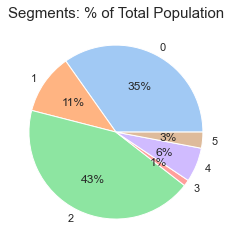

In [81]:
clus_counts = doctors.groupby(by='cluster')['cluster'].count()

clusters = list(clus_counts.index.values)
count = list(clus_counts.values)

colors = sns.color_palette('pastel')
plt.pie(count, labels = clusters, colors = colors, autopct='%.0f%%')
plt.title("Segments: % of Total Population",size = 15)
plt.show()

#### Mean value of each feature for each cluster

In [82]:
segment_means_df = doctors.groupby(by = 'cluster')[['Incidence rate', 'R rate','Satisfaction','Experience','Purchases']].mean()

#### Visualizing Cluster Feature Means

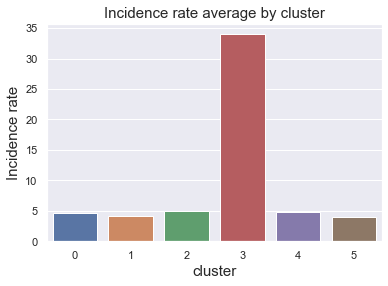

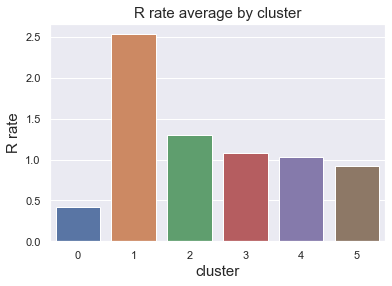

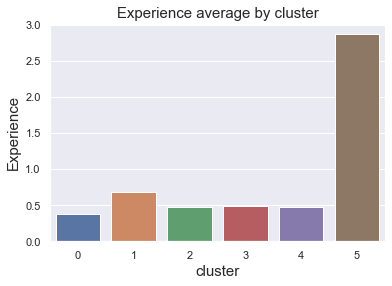

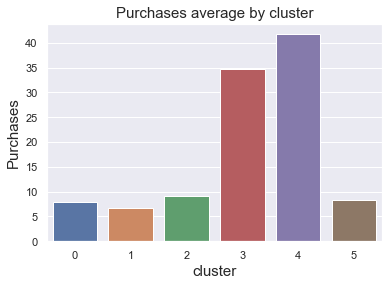

In [83]:
segment_means_df['cluster'] = list(np.arange(0,opt_clusters))
for i in segment_means_df.columns[:-1]:
    sns.barplot(x = "cluster", y = i, data = segment_means_df)
    plt.xlabel("cluster", fontsize = 15)
    plt.ylabel(i, fontsize = 15)
    plt.title('{} average by cluster'.format(i), fontsize = 15)
    plt.show()

### Smart Segmenting: What are the key features?

Incidence rate, R rate, Experience, and Purchases

### Smart Segmenting: What defines the new segments?

**Each segment has its own unique combination of features, however, stakeholders need to consider the size of the segments**

Below we have listed the magnitude of the features for each segment. In addition to the unique combination of feature magnitudes for each segment, it is also pertinent for stakeholders to understand the size of the segments. More specifically, we can see that almost 80% of the data is contained within "Segment 0" and "Segment 2".

#### Segment 0
* 43% of data
* low incidence rate
* medium r rate
* Low experience
* low purchase
    
#### Segment 1
* 2% of data
* high incidence rate
* medium r rate
* Low experience
* medium-high purchase

#### Segment 2
* 35% of data
* low incidence rate
* low r rate
* Low experience
* low purchase
        
#### Segment 3
* 6% of data
* low incidence rate
* medium r rate
* Low experience
* high purchase

#### Segment 4
* 11% of data
* low incidence rate
* high r rate
* Low experience
* low purchase
        
#### Segment 5
* 3% of data
* low incidence rate
* medium r rate
* high experience
* low purchase